In [ ]:
import subprocess
import sys
import urllib.request
import gzip
from Bio import SeqIO
import os
import glob
import numpy as np
from os import listdir
import pandas as pd
import jellyfish
import shlex
import mmh3
import matplotlib.pyplot as plt
import ahocorasick

In [ ]:
# in terminal whole big file
ls *.fna.gz | xargs -n 1 echo gunzip -c > generators
sbatch -c 4 --mem 10G --wrap='jellyfish count -m 25 -s 100M -t 4 -o output_canonical.jf -C -g generators -G 4'

In [ ]:
# under acheron/acheron
jellyfish dump -L 25 -U 1139 output_canonical.jf > best_kmers_canonical.jf
jellyfish histo -i 1 output_canonical.jf > histogram.txt

In [81]:
# how does histogram of initial output looks like without best-kmers filtering?
histogram_data = open("histogram.csv", encoding = "utf-8")
df = pd.read_csv(histogram_data, header = None, sep = " ", names = ["count", "no. of kmers"])
df["log no. of kmers"] = np.log(df["no. of kmers"])
df

,count,no. of kmers,log no. of kmers
0,1,93731889,18.355949
1,2,18102136,16.711541
2,3,13802404,16.440353
3,4,8823507,15.992930
4,5,3976182,15.195833
...,...,...,...
3811,9793,1,0.000000
3812,9828,1,0.000000
3813,9882,1,0.000000
3814,9908,1,0.000000


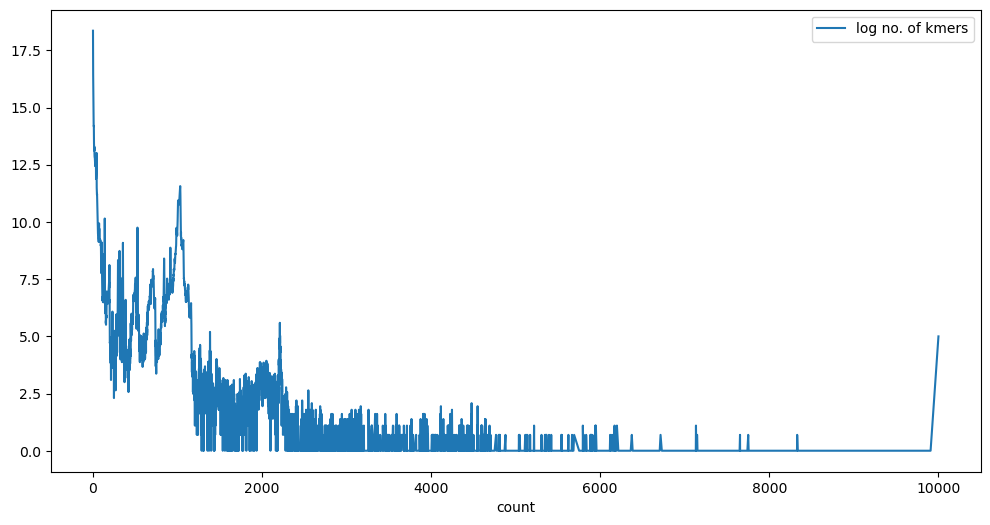

In [82]:
df.plot(kind = "line", x = "count", y = "log no. of kmers", figsize=(12,6))
plt.show()

In [10]:
all_kmers = open("mer_counts_dumps.jf", encoding = "utf-8")
len(all_kmers.readlines())

453468724

In [16]:
best_kmers = open("best_kmers_canonical.jf", encoding = "utf-8")
contents = best_kmers.readlines()
len(contents)

19918602

In [100]:
contents

['>185\n',
 'AAAAAAAAAAAAAAAAAAAAAAAAA\n',
 '>1029\n',
 'CCGGCGCATGGGCCGGGCTTTTCTC\n',
 '>1032\n',
 'CGGCATTGGCAAGCGCGAGCAAGAC\n',
 '>1009\n',
 'CCCGAAAGCAAATCCGCCCAACCCG\n',
 '>315\n',
 'CAGGATCAATGTACCACCATCGGCC\n',
 '>1045\n',
 'GAAGCCTCGAATTGCGATAAGTCTA\n',
 '>268\n',
 'ACATGACCTTTGACGGCTCAACACA\n',
 '>78\n',
 'CCATTCTGGCAGGGAGATGGGTAGA\n',
 '>1028\n',
 'GCAGTGAATAGACGAGGAGCAGGAA\n',
 '>140\n',
 'AGCAATGCGCAGGGCTTTTCCCCAT\n',
 '>140\n',
 'GAATATCAAGAAGAAACTTGGTATC\n',
 '>1033\n',
 'AGGACATGCAGACGCCGCCGAGCAG\n',
 '>31\n',
 'ATCTGTCAGTGAAACGCCGTCGGTC\n',
 '>46\n',
 'AGATGATCTTGCCAAGCGCAGCAAT\n',
 '>1033\n',
 'CCTGATAGCCGAAGCCGGATACGAC\n',
 '>1059\n',
 'TTCACGGCGCCGGGCGAATCCTGAA\n',
 '>40\n',
 'CCTGCTTGCAATCCGCTCCGGAGGC\n',
 '>34\n',
 'CGCTTCGTATCGAGAAACCGCATGA\n',
 '>49\n',
 'TAAAGCTAAGTAAGGGGAACTAAAA\n',
 '>1051\n',
 'CAGGAATGCTCTCGACCACGGACCA\n',
 '>1037\n',
 'ACCTCGAAGGTAAATTGCGCACTGG\n',
 '>30\n',
 'TCGTGGCCGAGCATGTGCCTGCCAA\n',
 '>1006\n',
 'TAACCAGCCTTGTGGGCGGTTTCGA\n',
 '>986\

In [113]:
good_kmers = []
for i,c in enumerate(contents):
    if len(good_kmers) > 1000:
        break
    elif i % 2 != 0:
        good_kmers.append(c[:-1])

In [ ]:
len(good_kmers)

In [ ]:
for i in good_kmers:
    good_kmers.append(reverse_complement(i))

In [18]:
#Generates the reverse complement of a given kmer
def reverse_complement(kmer):
	return ''.join([complement[base] for base in kmer[::-1]])

#Creates the needles (all kmers)
def needles(strain):
	kmers = ranks.index.values
	rank = ranks[strain+' RANK']
	aho = ahocorasick.Automaton()
	for i in range(0,len(kmers)):
		kmer = kmers[i]
		rev_c = reverse_complement(kmer)
		aho.add_word(kmer,(kmer,rank[kmer]))
		aho.add_word(rev_c,(kmer,rank[kmer]))
	aho.make_automaton()
	return(aho)

#Runs the ahocorasick algorithm to find the location of the kmers (needles) in the refrence genome (haystack) 
def find_needles(tup):
	soa, strain = tup
	aho = needles(strain)
	chromosome1, chromosome2, ref_file = haystacks(strain, soa)
	c1_index, c1_rank, c2_index, c2_rank = [], [], [], []
	for end_index, (kmer, rank) in aho.iter(chromosome1):
		c1_index.append(end_index)
		c1_dict[kmer] = end_index
		c1_rank.append(rank)
	for end_index, (kmer, rank) in aho.iter(chromosome2):
		c2_index.append(end_index)
		c2_dict[kmer] = end_index
		c2_rank.append(rank)
	return(soa, strain, ref_file, c1_index, c1_rank, c2_index, c2_rank, c1_dict, c2_dict)

best_kmers_canonical.jf
firstoutput1.jf
firstoutput.jf
GCF_000007125.1_ASM712v1.genomic.fna.gz
GCF_000007505.1_ASM750v1.genomic.fna
GCF_000007505.1_ASM750v1.genomic.fna.gz
GCF_000008145.1_ASM814v1.genomic.fna.gz
GCF_000016845.1_ASM1684v1.genomic.fna.gz
GCF_000017405.1_ASM1740v1.genomic.fna.gz
GCF_000018525.1_ASM1852v1.genomic.fna.gz
GCF_000018725.1_ASM1872v1.genomic.fna.gz
GCF_000018905.1_ASM1890v1.genomic.fna.gz
GCF_000022625.1_ASM2262v1.genomic.fna.gz
GCF_000022745.1_ASM2274v1.genomic.fna.gz
GCF_000054005.1_ASM5400v1.genomic.fna.gz
GCF_000157675.1_ASM15767v1.genomic.fna.gz
GCF_000157695.1_ASM15769v1.genomic.fna.gz
GCF_000157715.1_ASM15771v1.genomic.fna.gz
GCF_000157735.1_ASM15773v1.genomic.fna.gz
GCF_000157755.1_ASM15775v1.genomic.fna.gz
GCF_000157775.1_ASM15777v1.genomic.fna.gz
GCF_000157795.1_ASM15779v1.genomic.fna.gz
GCF_000157815.1_ASM15781v1.genomic.fna.gz
GCF_000157835.1_ASM15783v1.genomic.fna.gz
GCF_000157855.1_ASM15785v1.genomic.fna.gz
GCF_000157875.1_ASM15787v1.genomic.fna.g

output_canonical.jf
slurm-1735.out
slurm-1744.out


In [65]:
graph = open("histogram.txt", encoding = "utf-8")
pic = graph.readlines()
pic

FileNotFoundError: [Errno 2] No such file or directory: 'histogram.txt'

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq
from Bio.SeqIO.FastaIO import SimpleFastaParser

In [5]:
ls

add_reverse_complement.parquet
all_jellyfish_cmds.sh*
best_kmers_canonical.jf
firstoutput.tsv
GCF_000007125.1_ASM712v1.genomic.fna.gz
GCF_000007505.1_ASM750v1.genomic.fna
GCF_000007505.1_ASM750v1.genomic.fna.gz
GCF_000008145.1_ASM814v1.genomic.fna.gz
GCF_000016845.1_ASM1684v1.genomic.fna.gz
GCF_000017405.1_ASM1740v1.genomic.fna.gz
GCF_000018525.1_ASM1852v1.genomic.fna.gz
GCF_000018725.1_ASM1872v1.genomic.fna.gz
GCF_000018905.1_ASM1890v1.genomic.fna.gz
GCF_000022625.1_ASM2262v1.genomic.fna.gz
GCF_000022745.1_ASM2274v1.genomic.fna.gz
GCF_000054005.1_ASM5400v1.genomic.fna.gz
GCF_000157675.1_ASM15767v1.genomic.fna.gz
GCF_000157695.1_ASM15769v1.genomic.fna.gz
GCF_000157715.1_ASM15771v1.genomic.fna.gz
GCF_000157735.1_ASM15773v1.genomic.fna.gz
GCF_000157755.1_ASM15775v1.genomic.fna.gz
GCF_000157775.1_ASM15777v1.genomic.fna.gz
GCF_000157795.1_ASM15779v1.genomic.fna.gz
GCF_000157815.1_ASM15781v1.genomic.fna.gz
GCF_000157835.1_ASM15783v1.genomic.fna.gz
GCF_000157855.1_ASM15785v1.genomic.fna.gz
G

In [13]:
list = []
file = open("GCF_000007125.1_ASM712v1.genomic.fna.gz", "rb")
for title, seq in SimpleFastaParser(file):
    list.append(title)
list

[]

In [ ]:
#in terminal
chmod +x jellyfishcmd.sh
./jellyfishcmd.sh